Best parameters: {'svm__C': 50, 'svm__gamma': 'scale'}
Accuracy mean: 0.8649999999999999
Accuracy std: 0.052081666639999136
                precision    recall  f1-score   support

      chainsaw       0.93      0.95      0.94        40
    clock_tick       0.74      0.80      0.77        40
crackling_fire       0.78      0.78      0.78        40
   crying_baby       0.95      0.95      0.95        40
           dog       0.86      0.78      0.82        40
    helicopter       0.90      0.88      0.89        40
          rain       0.81      0.88      0.84        40
       rooster       0.93      0.93      0.93        40
     sea_waves       0.94      0.85      0.89        40
      sneezing       0.83      0.88      0.85        40

      accuracy                           0.86       400
     macro avg       0.87      0.86      0.87       400
  weighted avg       0.87      0.86      0.87       400



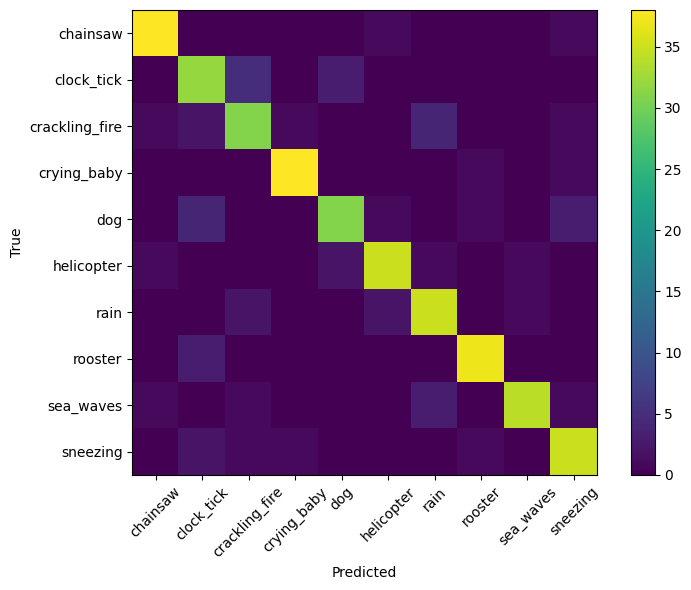

In [2]:
import os
import numpy as np
import librosa
import warnings
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GroupKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATASET_ROOT = "/kaggle/input/esc10rearranged/Data"

SAMPLE_RATE = 16000
AUDIO_LENGTH = SAMPLE_RATE * 5

N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 64


def pad_or_truncate(signal, target_len):
    if len(signal) >= target_len:
        return signal[:target_len]
    return np.pad(signal, (0, target_len - len(signal)), mode="constant")


def extract_features(y, sr):
    y = pad_or_truncate(y, AUDIO_LENGTH)

    mfcc = librosa.feature.mfcc(
        y=y, sr=sr,
        n_mfcc=N_MFCC,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )

    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    rms = librosa.feature.rms(y=y)

    features = np.vstack([
        mfcc, delta, delta2,
        chroma, contrast,
        zcr, rms
    ])

    return np.hstack([
        np.mean(features, axis=1),
        np.std(features, axis=1)
    ])


X, y, groups = [], [], []

classes = sorted(os.listdir(DATASET_ROOT))

for label, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_ROOT, class_name)

    for file_id, fname in enumerate(os.listdir(class_path)):
        if fname.lower().endswith(".wav"):
            path = os.path.join(class_path, fname)
            audio, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)

            X.append(extract_features(audio, sr))
            y.append(label)
            groups.append(f"{class_name}_{file_id}")

X = np.array(X)
y = np.array(y)
groups = np.array(groups)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.98, random_state=RANDOM_STATE)),
    ("svm", SVC(
        kernel="rbf",
        class_weight="balanced",
        probability=True,
        random_state=RANDOM_STATE
    ))
])

param_grid = {
    "svm__C": [5, 10, 50, 100],
    "svm__gamma": ["scale", 0.01]
}

cv = GroupKFold(n_splits=5)

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

grid.fit(X, y, groups=groups)

accuracy_scores = cross_val_score(
    grid.best_estimator_,
    X, y,
    cv=cv,
    groups=groups,
    scoring="accuracy"
)

y_pred = cross_val_predict(
    grid.best_estimator_,
    X, y,
    cv=cv,
    groups=groups
)

print("Best parameters:", grid.best_params_)
print("Accuracy mean:", accuracy_scores.mean())
print("Accuracy std:", accuracy_scores.std())

print(classification_report(y, y_pred, target_names=classes))

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm)
plt.colorbar()
plt.xticks(range(len(classes)), classes, rotation=45)
plt.yticks(range(len(classes)), classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
